<img src="siamese_network.png" style="width:238px;height:150px;float:middle">
以上為siamese network的計算流程<br>

### 請解壓縮data.rar，取得本程式之數據

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image

C:\Users\hong guo peng\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
examples_num = 20
img_width , img_height , channels = 28 , 28 , 1
way_num = 60
base_num = 5
input_num = 7

In [3]:
# Load Dataset
def load_data(root_dir):
    img_dirs = []
    for folder in os.listdir(root_dir):
        for character_folder in os.listdir(root_dir + '/{}'.format(folder)):
            img_dirs.append(os.path.join(root_dir , folder , character_folder))

    dataset = np.zeros([len(img_dirs) , examples_num , img_height , img_width] , dtype = np.float32)
    for i , folder in enumerate(img_dirs):
        for j , file in enumerate(os.listdir(folder)):
            imagePath = os.path.join(folder , file)
            image = Image.open(imagePath).resize((img_width , img_height))
            values = 1. - np.array(image , np.float32)
            dataset[i , j , : , :] = values

    return dataset

train_dataset = load_data('./data/training_image')
test_dataset = load_data('./data/testing_image')

In [4]:
aug = ImageDataGenerator(rotation_range = 25,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1 ,
                         shear_range = 0.2 ,
                         zoom_range = 0.2,
                         fill_mode = 'nearest')

def get_batch(data , way_num = 60 , input_num = 7 , base_num = 5):

    class_indices = np.random.choice(np.arange(len(data)) ,
                                     size = way_num ,
                                     replace = False)

    base_image_set = None
    input_image_set = None
    input_label_set = None
    for i , class_index in enumerate(class_indices):

        class_image = np.reshape(data[class_index] , [20 , 28 , 28 , 1])
        augmentation_data = aug.flow(np.reshape(class_image , [-1 , 28 , 28 , 1]) , np.arange(20))
        class_image = augmentation_data[0][0]

        sample_index = np.random.choice(np.arange(20) ,
                                        size = input_num + base_num ,
                                        replace = False)

        # base_image → [1 , 5 , 28 , 28 , 1]
        base_index = sample_index[:base_num]
        base_image = np.reshape(class_image[base_index] , [1 , base_num , 28 , 28 , 1])
        if base_image_set is None:
            base_image_set = base_image
        else:
            # base_image_set → [60 , 5 , 28 , 28 , 1] (執行迴圈60次，沿著axis 0，將base_image堆疊60次)
            # 總共60個class，每1個class有5張image
            base_image_set = np.concatenate([base_image_set , base_image] , axis = 0)

        input_index = sample_index[-input_num:]
        # input_image → [7 , 28 , 28 , 1]
        input_image = np.reshape(class_image[input_index] , [1 , input_num , 28 , 28 , 1])
        if input_image_set is None:
            input_image_set = input_image
        else:
            # input_image_set → [60 , 7 , 28 , 28 , 1] (執行迴圈60次，沿著axis 0，將input_image堆疊60次)
            # 總共60個class，每1個class有7張image
            input_image_set = np.concatenate([input_image_set , input_image] , axis = 0)

        # input_label → [1 , 7 , 60]
        # class 0的input_label[: , : , 0] = 1
        # class 為1的input_label[: , : , 1] = 1
        #                   ...
        # class 為59的input_label[: , : , 60] = 1
        input_label = np.zeros([1 , input_num , way_num])
        input_label[: , : , i] = 1
        if input_label_set is None:
            input_label_set = input_label
        else:
            # input_label_set → [60 , 7 , 60] (執行迴圈60次，沿著axis 0，將input_label堆疊60次)
            # 總共60個class，每1個class含有相同的7個相同的label，而每1個label的one-hot的深度當然為60
            input_label_set = np.concatenate([input_label_set , input_label] , axis = 0)

    return base_image_set , input_image_set , input_label_set

In [5]:
input_image = tf.placeholder(tf.float32 , [way_num , input_num , 28 , 28 , 1])
input_image_ = tf.reshape(input_image , [-1 , 28 , 28 , 1])

base_image = tf.placeholder(tf.float32 , [way_num , base_num , 28 , 28 , 1])
base_image_ = tf.reshape(base_image , [-1 , 28 , 28 , 1])

y_true = tf.placeholder(tf.float32 , [way_num , input_num , way_num])
y_true_ = tf.reshape(y_true , [-1 , way_num])

on_train = tf.placeholder(tf.bool)

In [6]:
def batch_norm_layer_part1(inputs , on_train , convolution):
    # the dimension you wanna normalize, here [0] for batch
    # for image, you wanna do [0 , 1 , 2] for [batch , height , width] but not channel
    if convolution:
        fc_mean , fc_var = tf.nn.moments(inputs , axes = [0 , 1 , 2] , name = 'mean_var')
    else:
        fc_mean , fc_var = tf.nn.moments(inputs , axes = [0] , name = 'mean_var')

    ema = tf.train.ExponentialMovingAverage(decay = 0.99)
    ema_apply_op = ema.apply([fc_mean , fc_var])
    mean = tf.cond(on_train , lambda : fc_mean , lambda : ema.average(fc_mean))
    var = tf.cond(on_train , lambda : fc_var , lambda : ema.average(fc_var))
    return mean , var , ema_apply_op

def batch_norm_layer_part2(inputs , mean , var):
    initializer = tf.contrib.layers.xavier_initializer()
    scale = tf.get_variable(initializer = tf.ones([1 , inputs.shape[-1].value]) , name = 'scale')
    shift = tf.get_variable(initializer = tf.zeros([1 , inputs.shape[-1].value]) , name = 'shift')
    temp = (inputs - mean) / tf.sqrt(var + 1e-8)
    outputs = tf.multiply(temp , scale) + shift
    return outputs

In [7]:
def feature_extractor(input_ , reuse = False):
    
    #------------------------------conv_layer------------------------------#
    ema_list = []
    for i in range(1 , 6):
        with tf.variable_scope('conv{}'.format(i)) as scope:
            if reuse : tf.get_variable_scope().reuse_variables()
            conv_output = tf.contrib.layers.conv2d(input_ , 64 , [3 , 3] ,
                                                   activation_fn = tf.nn.relu , padding='SAME' ,
                                                   weights_initializer = tf.contrib.layers.xavier_initializer_conv2d())
    
        with tf.variable_scope('conv{}_compute_mean_var'.format(i)):
            conv_mean , conv_var , conv_ema = batch_norm_layer_part1(conv_output , on_train , True)
    
        with tf.variable_scope(scope):
            conv_bn = batch_norm_layer_part2(conv_output , conv_mean , conv_var)
            conv_pooling = tf.contrib.layers.max_pool2d(conv_bn , [2 , 2] , padding = 'SAME')

        input_ = conv_pooling
        ema_list.append(conv_ema)

    update_ema = tf.group(ema_list)
    #------------------------------conv_layer------------------------------#
    

    #------------------------------flatten_layer------------------------------#
    with tf.variable_scope('flatten'):
        output_flatten = tf.contrib.layers.flatten(input_)
    #------------------------------flatten_layer------------------------------#
        
    return output_flatten , update_ema

In [8]:
with tf.variable_scope('feature_extractor'):
    # embedding_input → [60 * 7 , 64]
    embedding_input , ema_input = feature_extractor(input_image_ , reuse = False)
    # embedding_input → [60 , 60 * 7 , 64]
    embedding_input_copy = tf.tile(tf.expand_dims(embedding_input , axis = 0) , [way_num , 1 , 1])

    # embedding_base → [60 , 5 , 64]    
    embedding_base , ema_base = feature_extractor(base_image_ , reuse = True)
    embedding_base = tf.reshape(embedding_base , [-1 , base_num , embedding_base.shape[-1].value])
    # embedding_base_mean → [60 , 64]  
    embedding_base_mean = tf.reduce_mean(embedding_base , axis = 1)
    # embedding_base_copy → [60 , 60 * 7 , 64] 
    embedding_base_copy = tf.tile(tf.expand_dims(embedding_base_mean , axis = 1) , [1 , way_num * input_num , 1])

    update_ema = tf.group([ema_input , ema_base])


with tf.variable_scope('euclidean_distance'):
    distance = tf.reduce_sum(tf.pow(embedding_base_copy - embedding_input_copy , 2) , axis = -1)
    distance = tf.transpose(distance , [1 , 0])
    distance = tf.sqrt(tf.maximum(distance , 1e-9))

    
with tf.variable_scope('contrastive_loss'):
    margin = 4
    decision_similarity = y_true_
    similarity = tf.multiply(decision_similarity , tf.square(distance))
    dissimilarity = tf.multiply(1 - decision_similarity , tf.square(tf.maximum(margin - distance , 0)))
    contrastive_loss = tf.reduce_mean(similarity + dissimilarity)
    
    
with tf.variable_scope('optimizer'):
    train_op = tf.train.AdamOptimizer(1e-3).minimize(contrastive_loss)
    
    
with tf.variable_scope('accuracy'):    
    correct = tf.equal(tf.argmin(distance , 1) , tf.argmax(y_true_ , 1))
    correct = tf.cast(correct , tf.float32)
    accuracy = tf.reduce_mean(correct)

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

embedding_vector_list = []
for batch_i in range(0 , 3200):
    base_image_batch , input_image_batch , input_label_batch = get_batch(train_dataset)

    _  , _ , train_loss , train_accuracy = sess.run([train_op , update_ema , contrastive_loss , accuracy] ,
                                                     feed_dict = {input_image : input_image_batch ,
                                                                  y_true : input_label_batch ,
                                                                  base_image : base_image_batch ,
                                                                  on_train : True})
    
    if batch_i % 160 == 0:
        print('=' * 30)
        print('batch_i : {}'.format(batch_i))
        print('training_loss : {:.4f}'.format(train_loss))
        print('training_accuracy : {:.2%}'.format(train_accuracy))

        base_image_test , input_image_test , input_label_test = get_batch(test_dataset)
        test_loss , test_accuracy =  sess.run([contrastive_loss , accuracy] ,
                                              feed_dict = {input_image : input_image_test ,
                                                           y_true : input_label_test ,
                                                           base_image : base_image_test ,
                                                           on_train : False})
        print('*' * 30)
        print('testing_loss : {:.4f}'.format(test_loss))
        print('testing_accuracy : {:.2%}\n'.format(test_accuracy))

batch_i : 0
training_loss : 1.4197
training_accuracy : 8.81%
******************************
testing_loss : 15375825920.0000
testing_accuracy : 14.52%

batch_i : 160
training_loss : 0.1457
training_accuracy : 80.00%
******************************
testing_loss : 0.3814
testing_accuracy : 56.90%

batch_i : 320
training_loss : 0.1246
training_accuracy : 84.52%
******************************
testing_loss : 0.1677
testing_accuracy : 74.05%

batch_i : 480
training_loss : 0.1153
training_accuracy : 86.67%
******************************
testing_loss : 0.1548
testing_accuracy : 75.48%

batch_i : 640
training_loss : 0.1187
training_accuracy : 85.48%
******************************
testing_loss : 0.1534
testing_accuracy : 81.67%

batch_i : 800
training_loss : 0.0970
training_accuracy : 91.67%
******************************
testing_loss : 0.1313
testing_accuracy : 82.38%

batch_i : 960
training_loss : 0.1000
training_accuracy : 91.19%
******************************
testing_loss : 0.1216
testing_accu

### image檢索 → 要從input_image_search中找出與base_image_search最相近的35張image

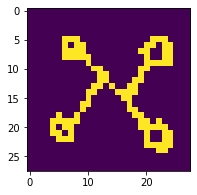

In [10]:
search_index = 0

fig, ax = plt.subplots(1 , 1 , figsize = (3 , 3))
ax.imshow(test_dataset[search_index , -1 , : , : ])

# base_image_search就是從test_dataset[search_index , : , : , :]中挑出前base_num張image接著複製120次(對應input_image_search的way_num種image)
# 最後計算這base_num張image的embedding vector的平均
base_image_search = np.tile(np.expand_dims(test_dataset[search_index , :base_num , : , :] , axis = -1) ,
                            [way_num , 1 , 1 , 1 , 1])

# input_image_search就是從test_dataset挑出way_num種image，再從每種image挑出input_num張image
# 最後計算這(way_num*input_num)張image的embedding vector
input_image_search = np.expand_dims(test_dataset[:way_num , base_num : base_num + input_num , : , :] , axis = -1)

# 計算base_image_search與input_image_search各自轉換的embedding vector的距離
search_distance = sess.run(distance , feed_dict = {input_image : input_image_search ,
                                                   base_image : base_image_search ,
                                                   on_train : False})

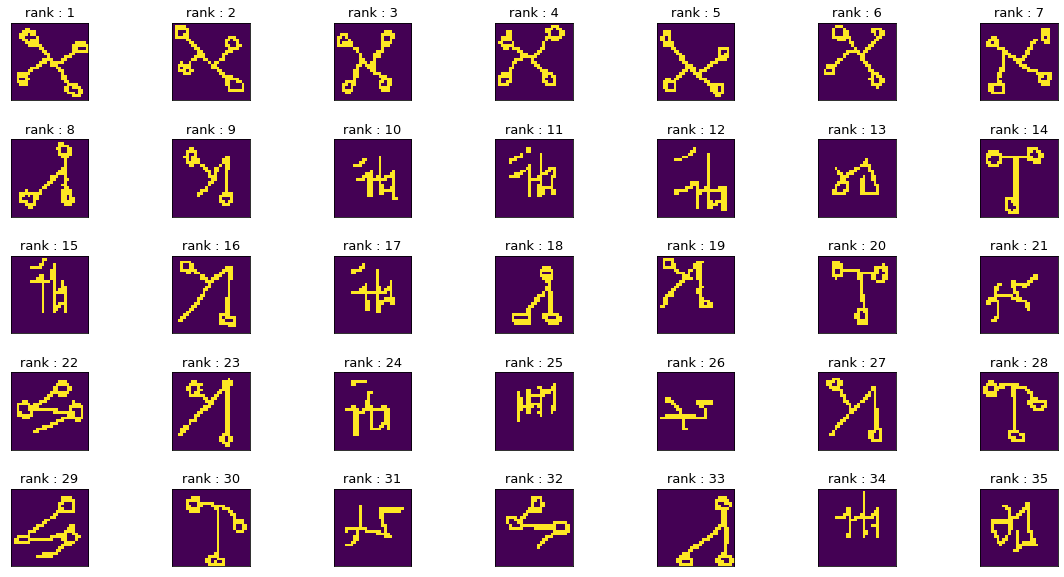

In [11]:
input_image_search_reshape = np.reshape(input_image_search , [-1 , 28 , 28 , 1])

# 並取出距離最短的前35名的index，即為top_35
top_35 = search_distance[: , 0].argsort()[:35]

fig , ax = plt.subplots(5 , 7 , figsize = (20 , 10))
plt.subplots_adjust(wspace = 0.1 , hspace = 0.5)
for i in range(0 , 5):
    for j in range(0 , 7):
        index = top_35[7 * i + j]
        ax[i , j].imshow(input_image_search_reshape[index , : , : , 0])
        ax[i , j].set_title('rank : {}'.format(7 * i + j + 1) , size = 13)
        ax[i , j].set_xticks([])
        ax[i , j].set_yticks([])

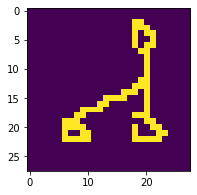

In [12]:
search_index = 5

fig, ax = plt.subplots(1 , 1 , figsize = (3 , 3))
ax.imshow(test_dataset[search_index , -1 , : , : ])

# base_image_search就是從test_dataset[search_index , : , : , :]中挑出前base_num張image接著複製120次(對應input_image_search的way_num種image)
# 最後計算這base_num張image的embedding vector的平均
base_image_search = np.tile(np.expand_dims(test_dataset[search_index , :base_num , : , :] , axis = -1) ,
                            [way_num , 1 , 1 , 1 , 1])

# input_image_search就是從test_dataset挑出way_num種image，再從每1種image挑出input_num張image
# 最後計算這(way_num*input_num)張image的embedding vector
input_image_search = np.expand_dims(test_dataset[:way_num , base_num : base_num + input_num , : , :] , axis = -1)

# 計算base_image_search與input_image_search各自轉換的embedding vector的距離
search_distance = sess.run(distance , feed_dict = {input_image : input_image_search ,
                                                   base_image : base_image_search ,
                                                   on_train : False})

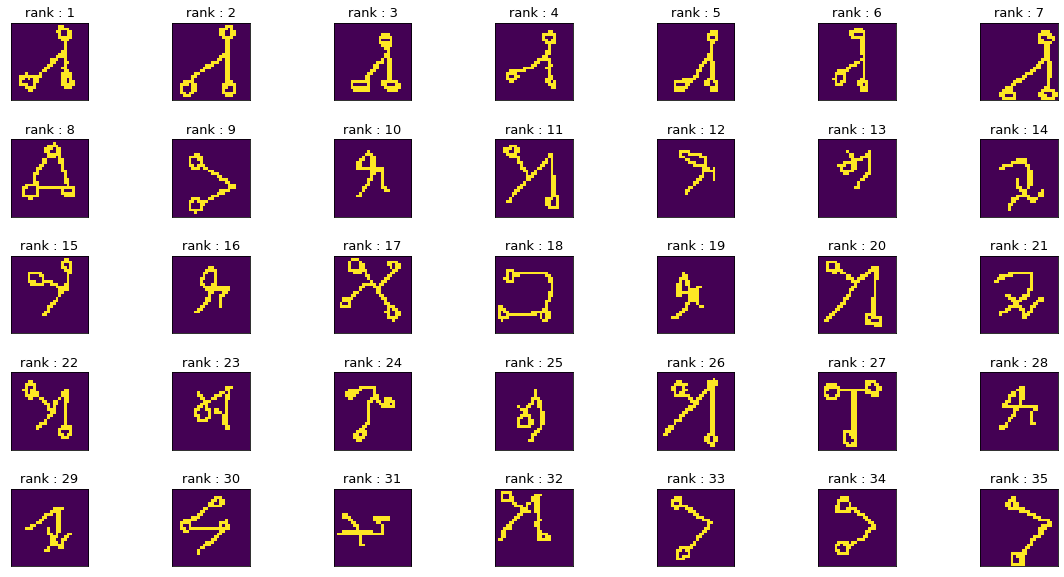

In [13]:
input_image_search_reshape = np.reshape(input_image_search , [-1 , 28 , 28 , 1])

# 並取出距離最短的前35名的index，即為top_35
top_35 = search_distance[: , 0].argsort()[:35]

fig , ax = plt.subplots(5 , 7 , figsize = (20 , 10))
plt.subplots_adjust(wspace = 0.1 , hspace = 0.5)
for i in range(0 , 5):
    for j in range(0 , 7):
        index = top_35[7 * i + j]
        ax[i , j].imshow(input_image_search_reshape[index , : , : , 0])
        ax[i , j].set_title('rank : {}'.format(7 * i + j + 1) , size = 13)
        ax[i , j].set_xticks([])
        ax[i , j].set_yticks([])

### 從test_dataset挑出一些有相似特徵的image

可以從結果發現不同種類的image所計算的平均embedding vector的距離越小 越會有相同的特徵

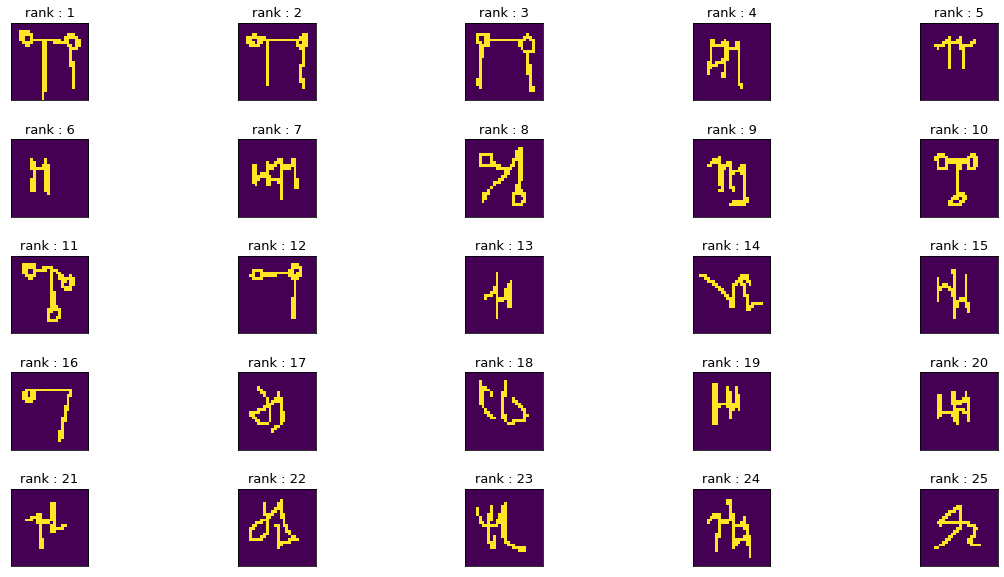

In [14]:
base_image_search = np.expand_dims(test_dataset[:way_num , :base_num , : , :] , axis = -1)

# 計算base_image_search中每1種image的embedding vector的平均
embedding_base_vector = sess.run(embedding_base_mean , feed_dict = {base_image : base_image_search ,
                                                                    on_train : False})

# 計算embedding_base_vector[search_index , :]與每1種embedding_base_vector[i , :]的距離
search_index = 4
distance_set = np.zeros(way_num)
for i in range(0 , way_num):
    diff_vector = embedding_base_vector[search_index , :] - embedding_base_vector[i , :]
    search_distance = np.linalg.norm(diff_vector)
    distance_set[i] = search_distance

# 並取出距離最短的前25名的index，即為top_25   
top_25 = distance_set.argsort()[:25]

fig , ax = plt.subplots(5 , 5 , figsize = (20 , 10))
plt.subplots_adjust(wspace = 0.1 , hspace = 0.5)
for i in range(0 , 5):
    for j in range(0 , 5):
        index = top_25[5 * i + j]
        ax[i , j].imshow(base_image_search[index , 0 , : , : , 0])
        ax[i , j].set_title('rank : {}'.format(5 * i + j + 1) , size = 13)
        ax[i , j].set_xticks([])
        ax[i , j].set_yticks([])    

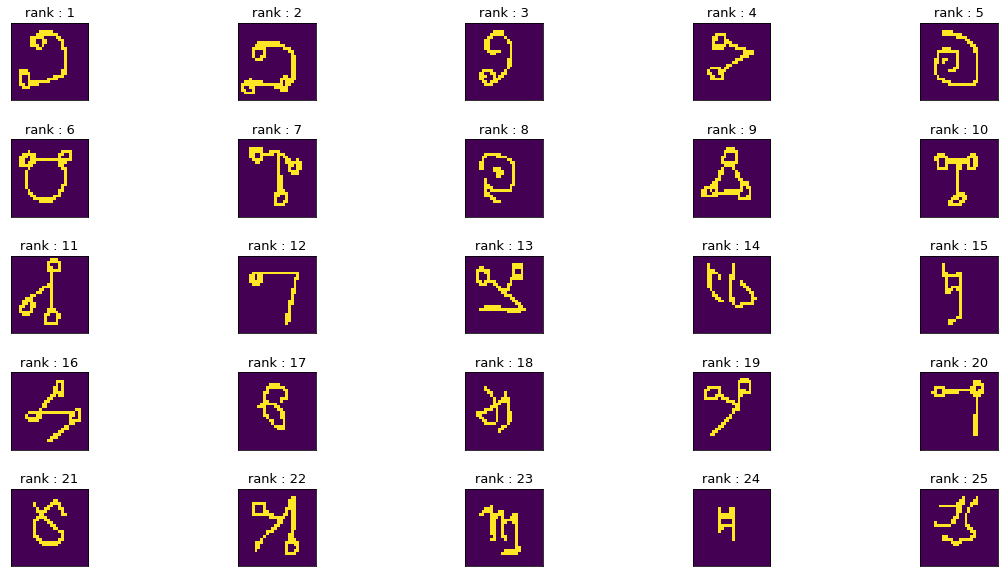

In [15]:
base_image_search = np.expand_dims(test_dataset[:way_num , :base_num , : , :] , axis = -1)

# 計算base_image_search中每1種image的embedding vector的平均
embedding_base_vector = sess.run(embedding_base_mean , feed_dict = {base_image : base_image_search ,
                                                                    on_train : False})

# 計算embedding_base_vector[search_index , :]與每1種embedding_base_vector[i , :]的距離
search_index = 8
distance_set = np.zeros(way_num)
for i in range(0 , way_num):
    diff_vector = embedding_base_vector[search_index , :] - embedding_base_vector[i , :]
    search_distance = np.linalg.norm(diff_vector)
    distance_set[i] = search_distance

# 並取出距離最短的前25名的index，即為top_25 
top_25 = distance_set.argsort()[:25]

fig , ax = plt.subplots(5 , 5 , figsize = (20 , 10))
plt.subplots_adjust(wspace = 0.1 , hspace = 0.5)
for i in range(0 , 5):
    for j in range(0 , 5):
        index = top_25[5 * i + j]
        ax[i , j].imshow(base_image_search[index , 0 , : , : , 0])
        ax[i , j].set_title('rank : {}'.format(5 * i + j + 1) , size = 13)
        ax[i , j].set_xticks([])
        ax[i , j].set_yticks([])    